In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from WoLF_lib import *

# Single run of WoLF-PHC

In [2]:
price_grid = np.linspace(0,1,7)
k = len(price_grid)
q = np.zeros((k,k))
p_table = np.zeros((2, 10))
p_table[0,0] = np.random.choice(price_grid)
p_table[1,0] = np.random.choice(price_grid)
for t in range(1,10):
    if t%2 == 0:
        p_table[0,t] = p_table[0,t-1]
        p_table[1,t] =  np.random.choice(price_grid)
    else:
        p_table[1,t] = p_table[1,t-1]
        p_table[0,t] =  np.random.choice(price_grid)

print(p_table)


[[0.33333333 0.5        0.5        0.16666667 0.16666667 0.33333333
  0.33333333 0.16666667 0.16666667 0.5       ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.         0.
  0.5        0.5        0.16666667 0.16666667]]


In [3]:
res=q_func_wolf(q, 0.3, 0.95, p_table, price_grid, 0, 1, 9)
print(res)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.06145833 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


In [4]:
a,b,c=WoLF_PHC(0.3, 0.2, 0.6, 0.95, np.linspace(0,1,7), 500000)

In [5]:
c[:, 0:20]

array([[1.        , 0.83333333, 0.16666667, 0.16666667, 0.83333333,
        0.83333333, 0.83333333, 0.83333333, 0.16666667, 0.16666667,
        0.83333333, 0.83333333, 0.16666667, 0.16666667, 0.5       ,
        0.5       , 0.        , 0.        , 0.66666667, 0.66666667],
       [0.16666667, 0.83333333, 0.83333333, 0.        , 0.        ,
        0.66666667, 0.66666667, 1.        , 1.        , 0.        ,
        0.        , 0.16666667, 0.16666667, 0.83333333, 0.83333333,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]])

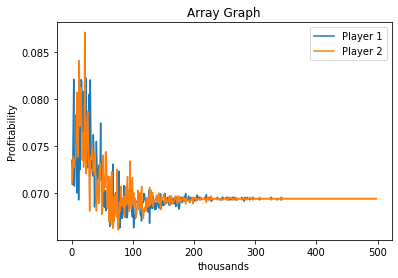

In [6]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, a)
plt.plot(x_values, b)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()